# Conceptual

### 1. Using basic statistical properties of the variance, as well as single variable calculus, derive (5.6). In other words, prove that $\alpha$ given by (5.6) does indeed minimize $Var(\alpha X + (1 − \alpha) Y)$

Use:
$$
Var(aX + bY) = a^2 Var(X) + b^2 Var(y) + 2Cov(X, Y)
$$

Solution:
$$
f(\alpha) = Var(\alpha X + (1 − \alpha) Y) = \alpha^2 \sigma_X^2 + (1 - \alpha) \sigma_Y^2 + 2\alpha(1-\alpha) \sigma_{XY} \\
\iff \frac{\partial f}{\partial \alpha} = 0 \implies \
2\alpha \sigma_X^2 - 2 \sigma_Y^2 + 2 \alpha \sigma_Y^2 + 2 \sigma_{XY} - 4 \alpha \sigma_{XY} = 0 \\
\implies \alpha = \frac{ \sigma_Y^2 - \sigma_{XY} }{ \sigma_X^2 + \sigma_Y^2 - 2 \sigma_{XY} }
$$

### 2. We will now derive the probability that a given observation is part of a bootstrap sample. Suppose that we obtain a bootstrap sample from a set of $n$ observations.
a) What is the probability that the first bootstrap observation is not the jth observation from the original sample? Justify your answer.
$$
(n - 1) / n = 1 - \frac{1}{n}
$$

b) What is the probability that the second bootstrap observation is not the jth observation from the original sample?
$$
(n - 1) / n = 1 - \frac{1}{n}
$$
c) Argue that the probability that the jth observation is not in the bootstrap sample is $(1 − 1/n)^n$
- jth observation cannot be the first, second, ... nth bootstrap sample: $(1 − 1/n)^n$

d) When $n = 5$, what is the probability that the jth observation is in the bootstrap sample?
$$
1 - (1 − 1/n)^n = 1 - (1 − 1/5)^5 = 1 - 0.33 = 0.67 
$$

e) When $n = 100$, what is the probability that the jth observation is in the bootstrap sample?
$$
1 - (1 − 1/n)^n = 1 - (1 − 1/100)^{100} = 1 - 0.366 = 0.634
$$

f) When $n = 10 000$, what is the probability that the jth observation is in the bootstrap sample?
$$
1 - (1 − 1/n)^n = 1 - (1 − 1/10000)^{10000} = 1 - 0.366 = 0.632
$$

g) Create a plot that displays, for each integer value of n from 1 to 100, 000, the probability that the jth observation is in the bootstrap sample. Comment on what you observe
- The probability that any of the observations is in the bootstrap sample for large values of $n$ is around 0.632 (or $1 - \frac{1}{e})$

In [35]:
import matplotlib.pyplot as plt
import numpy as np

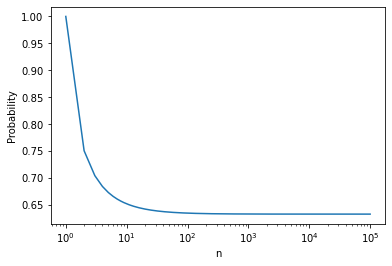

In [40]:
x = list(range(1, 100000))
y = [1 - (1 - 1/n)**n for n in x]
fig, ax = plt.subplots(1, 1)
ax.set(xscale = "log", xlabel = "n", 
       ylabel = "Probability")
ax.plot(x, y)

(h) We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time we record whether or not the fourth observation is contained in the bootstrap sample.
- The simulation confirms the above considerations

In [33]:
samples, n, j = 10000, 100, 4
present_count = 0
for s in range(samples):
    bootstrap = np.random.randint(1, 100, 100)
    if j in bootstrap: present_count += 1
print(f"Proportion of bootstrap samples containing j: {present_count/samples}")

Proportion of bootstrap samples containing j: 0.6321


### 3. We now review k-fold cross-validation.
(a) Explain how k-fold cross-validation is implemented
- We split the dataset into $k$ disjoint subsets. Then, we fit our model $k$ times, each time using different combination of $k-1$ subsets (concatenated together) for training, and then, evaluating the model performance on the remaining subset not used for training. Cross-validation performance of the model is the average validation performance across the $k$ runs

(b) What are the advantages and disadvantages of k-fold crossvalidation relative to:

i. The validation set approach?
- K-fold CV estimate is less biased - the model will have been tested on all samples. Validation set performance varies depending on the data that was included in the training vs. validation set
- K-fold is computationally more expensive (we train the model $k$ times)

ii. LOOCV?
- K-fold CV estimate is more biased - LOOCV uses almost all possible training data to fit the model
- K-fold CV estimate has less variance - in LOOCV the training subsets overlap almost exactly. And the mean of many highly correlated quantities has a higher variance 
- K-fold CV estimate is computationally less expensive - LOOCV requires training the model $k$ times

> _The source of confusion though is that when people talk about LOOCV leading to high variability, they aren't talking about the predictions made by the many models built during that loop of cross-validation on the holdout sets. Instead, they are talking about how much variability your final chosen model (the one chosen via LOOCV) would have if you train that exact model/parameters on new training sets - training sets your model haven't seen before. In this case, variability would be high._

### 4. Suppose that we use some statistical learning method to make a prediction for the response $Y$ for a particular value of the predictor $X$. Carefully describe how we might estimate the standard deviation of our prediction.
- We can create $n$ bootstrap samples from our original dataset $D$. Then, we fit our model on each of the bootstrap samples and calculate $Y_i = f_i(X)$ where $f_i$ is the i'th model fit on i'th bootstrap sample. We can estimate the SD of our prediction with: 
$$
\hat{\sigma} = \sqrt{ \frac{1}{B-1} \sum_{i=0}^{B} (f_i(X) - \bar{f_i(X)})^2}
$$

# Applied

In [291]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import scipy
from sklearn import metrics

### 5. In Chapter 4, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

(a) Fit a logistic regression model that uses income and balance to predict default

In [41]:
default_df = pd.read_csv("../data/Default.csv", index_col=0)
default_df["student"] = default_df["student"].map(lambda x: 1 if x == "Yes" else 0)
default_df["default"] = default_df["default"].map(lambda x: 1 if x == "Yes" else 0)
default_df = sm.add_constant(default_df)

In [42]:
errors = []
for i in range(3):
    D_train, D_test = train_test_split(default_df, test_size=0.2, random_state=i)
    X_train, X_test = D_train.drop(columns=["default", "student"]), D_test.drop(columns=["default", "student"])
    y_train, y_test = D_train["default"], D_test["default"]

    model = sm.Logit(y_train, X_train).fit()
    y_pred = (model.predict(X_test) > 0.5).map(int).values
    df_cm = metrics.confusion_matrix(y_test.values, y_pred)
    error = 1 - metrics.accuracy_score(y_test, y_pred)
    errors.append(error)

Optimization terminated successfully.
         Current function value: 0.077979
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077671
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078693
         Iterations 10


(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

ii. Fit a multiple logistic regression model using only the training observations

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified

(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

- See above

- Below are mean error and standard deviation for the error

In [43]:
np.mean(errors), np.std(errors, ddof=1)

(0.028000000000000025, 0.0010000000000000009)

(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

- The test error is very similar - including the variable `student` does not lead to a reduction in the test error rate

In [44]:
D_train, D_test = train_test_split(default_df, test_size=0.2, random_state=i)
X_train, X_test = D_train.drop(columns=["default"]), D_test.drop(columns=["default"])
y_train, y_test = D_train["default"], D_test["default"]

model = sm.Logit(y_train, X_train).fit()
y_pred = (model.predict(X_test) > 0.5).map(int).values
df_cm = metrics.confusion_matrix(y_test.values, y_pred)
error = 1 - metrics.accuracy_score(y_test, y_pred)
print(f"Error: {error}")

Optimization terminated successfully.
         Current function value: 0.078087
         Iterations 10
Error: 0.028000000000000025


In [45]:
error

0.028000000000000025

### 6. We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the glm() function. Do not forget to set a random seed before beginning your analysis.

(a) Determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.
- As seen below, the standard errors are: 3e-5 (balance), 3.7e-6 (income)

In [62]:
default_df = pd.read_csv("../data/Default.csv", index_col=0)
default_df["student"] = default_df["student"].map(lambda x: 1 if x == "Yes" else 0)
default_df["default"] = default_df["default"].map(lambda x: 1 if x == "Yes" else 0)

In [63]:
X_train = default_df.drop(columns=["default", "student"])
y_train = default_df[["default"]]
model = sm.Logit(y_train, X_train)
results = model.fit().summary()
results

Optimization terminated successfully.
         Current function value: 0.173456
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:                 -0.1878
Time:                        17:17:35   Log-Likelihood:                -1734.6
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
balance        0.0004   7.03e-05      5.797      0.000       0.000       0.001
income        -0.0001    3.7e-06    -34.025      0.000      -0.000      -0.000
==============================================================================
"""

(b) - (d) Estimate the standard errors using bootstrapping
- Standard error estimates are lower for both: balance (1.9e-6) and income (1.6e-7) (compared to std error estimates from the linear regression model itself)

In [68]:
B = 50
std_balance, std_income = [], []
for i in range(B):
    sample = default_df.sample(len(default_df), replace=True)
    X_train_sample = sample.drop(columns=["default", "student"])
    y_train_sample = sample[["default"]]
    model = sm.Logit(y_train_sample, X_train_sample)
    results = model.fit().summary()
    std_balance.append(float(results.tables[1].data[1][2].strip()))
    std_income.append(float(results.tables[1].data[2][2].strip()))
np.std(std_balance, ddof=1), np.std(std_income, ddof=1)

Optimization terminated successfully.
         Current function value: 0.181056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.166330
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164672
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.167739
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.179511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.172647
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.168203
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.176467
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177877
  

(1.977102600746242e-06, 1.5978314385824458e-07)

### 7. In Sections 5.3.2 and 5.3.3, we saw that the `cv.glm()` function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just the `glm()` and `predict.glm()` functions, and a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the `Weekly` data set. Recall that in the context of classification problems, the LOOCV error is given in (5.4).

(a) Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2`

In [140]:
weekly_df = pd.read_csv("../data/Weekly.csv", index_col=0)
weekly_df["Direction"] = weekly_df["Direction"].map(lambda x: 1 if x == "Up" else 0)
weekly_df = sm.add_constant(weekly_df)

In [141]:
X_train = weekly_df[["Lag1", "Lag2"]]
y_train = weekly_df[["Direction"]]
model = sm.Logit(y_train, X_train)
results = model.fit().summary()
results

Optimization terminated successfully.
         Current function value: 0.689280
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1087
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:               -0.003375
Time:                        17:59:38   Log-Likelihood:                -750.63
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lag1          -0.0322      0.026     -1.235      0.217      -0.083       0.019
Lag2           0.0664      0.026      2.511      0.012       0.015       0.118
==============================================================================
"""

(b) Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2` using all but the first observation

In [142]:
X_train = weekly_df[["Lag1", "Lag2"]][1:]
y_train = weekly_df[["Direction"]][1:]
model2 = sm.Logit(y_train, X_train)
results = model2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.689240
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1088
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:               -0.003483
Time:                        17:59:41   Log-Likelihood:                -749.89
converged:                       True   LL-Null:                       -747.29
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lag1          -0.0318      0.026     -1.223      0.221      -0.083       0.019
Lag2           0.0670      0.026      2.531      0.011       0.015       0.119
==============================================================================
"""

(c) Use the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if `P(Direction="Up"|Lag1, Lag2) > 0.5`. Was this observation correctly classified?
- The observation was incorrectly classified

In [143]:
pred = results.predict(weekly_df[["Lag1", "Lag2"]].iloc[0])
true = weekly_df[["Direction"]].iloc[0]
print(f"True: {true.values[0]}, prediction: {pred.values[0]}")

True: 0, prediction: 0.5198219840963214


(d) Write a for loop from `i = 1` to `i = n`, where n is the number of observations in the data set, that performs each of the following
steps:
i. Fit a logistic regression model using all but the ith observation to predict `Direction` using `Lag1` and `Lag2`.

ii. Compute the posterior probability of the market moving up for the ith observation.

iii. Use the posterior probability for the ith observation in order to predict whether or not the market moves up.

iv. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.

In [144]:
errors = 0
for i in range(len(weekly_df)):
    mask = np.array([True for _ in range(len(weekly_df))])
    mask[i] = False
    X_train = weekly_df[["Lag1", "Lag2"]][mask]
    y_train = weekly_df[["Direction"]][mask]
    model = sm.Logit(y_train, X_train)
    results = model.fit(disp=0)
    pred = results.predict(weekly_df[["Lag1", "Lag2"]][~mask])
    errors += int((pred.values[0] > 0.5) != weekly_df[["Direction"]][mask].values[0])
print(f"Error rate: {errors/len(weekly_df)}")

Error rate: 0.5316804407713499


(e) Take the average of the n numbers obtained in (d)iv in order to obtain the LOOCV estimate for the test error. Comment on the results.
- The LOOCV error rate estimate is 53\% 

### 8. We will now perform cross-validation on a simulated data set
(a) Generate a simulated data set as follows:
```
> set .seed (1)
> y= rnorm (100)
> x= rnorm (100)
> y=x -2* x^2+ rnorm (100)
```
In this data set, what is `n` and what is `p`? Write out the model used to generate the data in equation form.
- $y = x-2x^2 + \epsilon, \epsilon \sim N(0, 1)$. $n=100, p=2$

In [264]:
np.random.seed(42)
x = np.random.normal(size=100)
y = -x + -2*np.square(x) + np.random.normal(size=100)
data = pd.DataFrame({"y": y, "x": x})

(b) Create a scatterplot of X against Y . Comment on what you find.
- Typical quadratic plot with noise

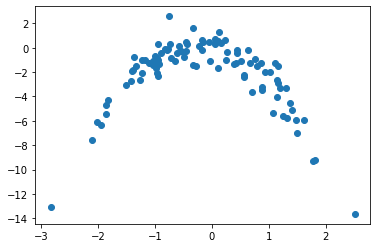

In [284]:
plt.scatter(x, y)

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:
- $Y = \beta_0 + \beta_1X + \epsilon$
- $Y = \beta_0 + \beta_1X + \beta_2 X^2 + \epsilon$
- $Y = \beta_0 + \beta_1X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$
- $Y = \beta_0 + \beta_1X + \beta_2 X^2 + \beta_3 X^3 + + \beta_4 X^4 + \epsilon$

In [273]:
def loocv(data: pd.DataFrame, formula: str):
    """Compute LOOCV Error rate"""
    np.random.seed(42)
    error = 0
    for i in range(len(data)):
        mask = np.array([True for _ in range(len(data))])
        mask[i] = False
        y, x = data[mask]["y"], data[mask]["x"]
        model = smf.ols(formula=formula, data=data[mask]).fit()
        pred = model.predict(data[~mask])
        error += abs(pred.values - data[~mask]["y"].values)
    return model, error

In [275]:
formulas = [
    "y ~ x", "y ~ x + np.power(x, 2)", "y ~ x + np.power(x, 2) + np.power(x, 3)", "y ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4)"
]
for f in formulas:
    model, error = loocv(data, f)
    models.append(model)
    print(f"Error for {f}: {error}")

Error for y ~ x: [200.68630758]
Error for y ~ x + np.power(x, 2): [74.55874723]
Error for y ~ x + np.power(x, 2) + np.power(x, 3): [76.33081635]
Error for y ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4): [79.40971083]


(d) Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?
- Different results although still the minimum error is for a quadratic curve without higher order terms

In [276]:
np.random.seed(41)
x = np.random.normal(size=100)
y = -x + -2*np.square(x) + np.random.normal(size=100)
data = pd.DataFrame({"y": y, "x": x})

In [277]:
formulas = [
    "y ~ x", "y ~ x + np.power(x, 2)", "y ~ x + np.power(x, 2) + np.power(x, 3)", "y ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4)"
]
models = []
for f in formulas:
    model, error = loocv(data, f)
    models.append(model)
    print(f"Error for {f}: {error}")

Error for y ~ x: [200.68630758]
Error for y ~ x + np.power(x, 2): [74.55874723]
Error for y ~ x + np.power(x, 2) + np.power(x, 3): [76.33081635]
Error for y ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4): [79.40971083]


(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.
- The second one (quadratic term). This is expected as the higher order polynomials overfit to the data and fit to noise

(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?
- The only statistically significant coefficinets are the $\beta_1$ and $\beta_2$, as expected (because they represent the true data generation equation)

In [279]:
models[-1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     194.4
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           1.50e-44
Time:                        15:58:07   Log-Likelihood:                -131.96
No. Observations:                  99   AIC:                             273.9
Df Residuals:                      94   BIC:                             286.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0474      0.152      0.312      0.756      -0.255       0.349
x                 -1.0232      0.151     -6.786      0.000      -1.323      -0.724
np.power(x, 2)    -1.9881      0.166    -11.954      0.000      -2.318      -1.658
np.power(x, 3)     0.0306      0.048      0.638      0.525      -0.065       0.126
np.power(x, 4)     0.0071      0.029      0.248      0.805      -0.050       0.064
==============================================================================
Omnibus:                        1.776   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.412   Jarque-Bera (JB):                1.205
Skew:                           0.198   Prob(JB):                        0.548
Kurtosis:                       3.367   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 9. We will now consider the Boston housing data set, from the MASS library.
(a) Based on this data set, provide an estimate for the population mean of `medv`. Call this estimate $\hat{\mu}$
- $\hat{\mu} = 22.53$

In [285]:
boston_df = pd.read_csv("../data/Boston.csv", index_col=0)

In [288]:
boston_df.medv.mean()

22.532806324110698

(b) Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result.
Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.
- 0.40886 (using scipy.stats.sem as well as manually computing using the hint provided)

In [296]:
scipy.stats.sem(boston_df.medv), np.std(boston_df.medv, ddof=1) / np.sqrt(len(boston_df))

(0.40886114749753505, 0.4088611474975351)

(c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from (b)?
- 0.42. Very close

In [304]:
np.std([boston_df.medv.sample(n=len(boston_df), replace=True).mean() for _ in range(100)], ddof=1)

0.4194536148956185

(d) Based on your bootstrap estimate from (c), provide a 95 % confidence interval for the mean of `medv`. Hint: You can approximate a 95% confidence interval using the formula
$$
[\hat{\mu} - 2SE(\hat{\mu}), \hat{\mu} + 2SE(\hat{\mu})]
$$
- 95% confidence interval is: [21.69, 23.37]

(e) Based on this data set, provide an estimate, $\hat{\mu}_{med}$, for the median value of `medv` in the population.

In [308]:
boston_df.medv.median()

21.2

(f) We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.
- Std error for the median is 0.36 which is a bit smaller than the std error for the mean

In [311]:
np.std([boston_df.medv.sample(n=len(boston_df), replace=True).median() for _ in range(100)], ddof=1)

0.3649007060181236

(g) Based on this data set, provide an estimate for the tenth percentile of `medv` in Boston suburbs. Call this quantity $\hat{\mu}_{0.1}$

In [312]:
boston_df.medv.quantile(0.1)

12.75

(h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$ Comment on your findings.
- Standard error for the tenth percentile is ~0.5 

In [314]:
np.std([boston_df.medv.sample(n=len(boston_df), replace=True).quantile(0.1) for _ in range(100)], ddof=1)

0.5180957752416364